In [1]:
import csv
import nest_asyncio

nest_asyncio.apply()

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from pytz import timezone; 

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [3]:
seed(10)
tf.random.set_seed(10)

In [4]:
dataset = 'full_capture20110818_preprocessed_1s.csv'

In [5]:
df = pd.read_csv (dataset, parse_dates=True, index_col='frame.time')
df.index = df.index.tz_convert(tz='Europe/Berlin')
df.head()

,frame_len_skew,frame_len_kurt,tcp_time_delta_skew,tcp_time_delta_kurt,tcp_window_size_skew,tcp_window_size_kurt,Class
frame.time,,,,,,,
2011-08-18 10:19:13+02:00,-0.003237,-1.956530,7.084053,65.006631,1.767655,1.306047,0.0
2011-08-18 10:19:14+02:00,0.147831,-1.925475,9.451039,115.146129,1.712910,1.087040,0.0
2011-08-18 10:19:15+02:00,0.221698,-1.905860,11.189152,163.612912,1.876652,1.743885,0.0
2011-08-18 10:19:16+02:00,0.283596,-1.866540,11.860539,171.790428,1.451439,0.359079,0.0
2011-08-18 10:19:17+02:00,0.275080,-1.886000,13.985521,231.092859,1.453618,0.273508,0.0


In [6]:
df.dropna(inplace=True)
print(df.isnull().sum())
df.info()

frame_len_skew          0
frame_len_kurt          0
tcp_time_delta_skew     0
tcp_time_delta_kurt     0
tcp_window_size_skew    0
tcp_window_size_kurt    0
Class                   0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8794 entries, 2011-08-18 10:19:13+02:00 to 2011-08-18 12:45:55+02:00
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   frame_len_skew        8794 non-null   float64
 1   frame_len_kurt        8794 non-null   float64
 2   tcp_time_delta_skew   8794 non-null   float64
 3   tcp_time_delta_kurt   8794 non-null   float64
 4   tcp_window_size_skew  8794 non-null   float64
 5   tcp_window_size_kurt  8794 non-null   float64
 6   Class                 8794 non-null   float64
dtypes: float64(7)
memory usage: 549.6 KB


In [7]:
new_df = df.drop(columns=['Class'])
new_df = new_df[:'2011-08-18 11:52:53']
new_df.shape

(5636, 6)

In [10]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["date.autoformatter.minute"] = "%H:%M"

[Text(0.5, 0, 'Tempo'), Text(0, 0.5, 'Skewness')]

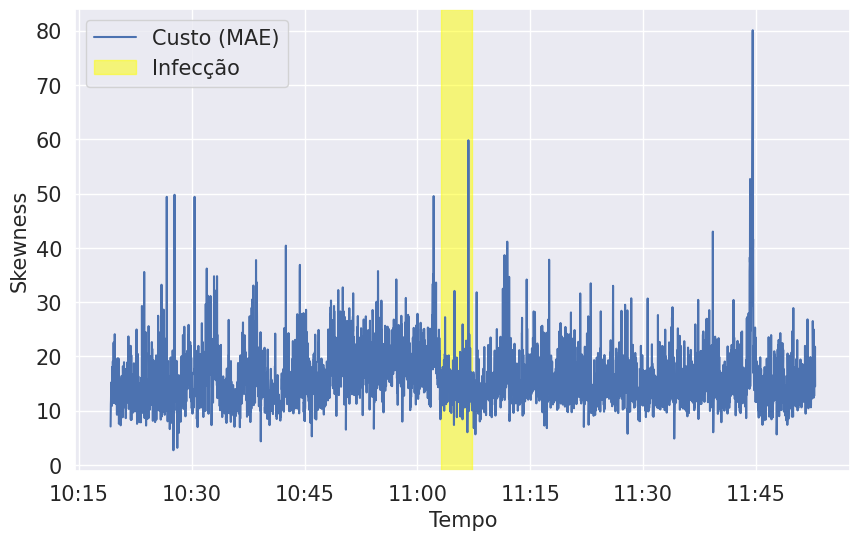

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['timezone'] = 'Europe/Berlin'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

axs.plot(new_df['tcp_time_delta_skew'])
axs.axvspan(pd.to_datetime('2011-08-18 11:03:05').tz_localize('Europe/Berlin'), pd.to_datetime('2011-08-18 11:07:15').tz_localize('Europe/Berlin'), color='yellow', alpha=0.5, label='Infecção')
labels = ['Custo (MAE)', 'Infecção']
axs.legend(loc="upper left", labels=labels)
axs.set(xlabel='Tempo', ylabel='Skewness')

[Text(0.5, 0, 'Tempo'), Text(0, 0.5, 'Kurtosis')]

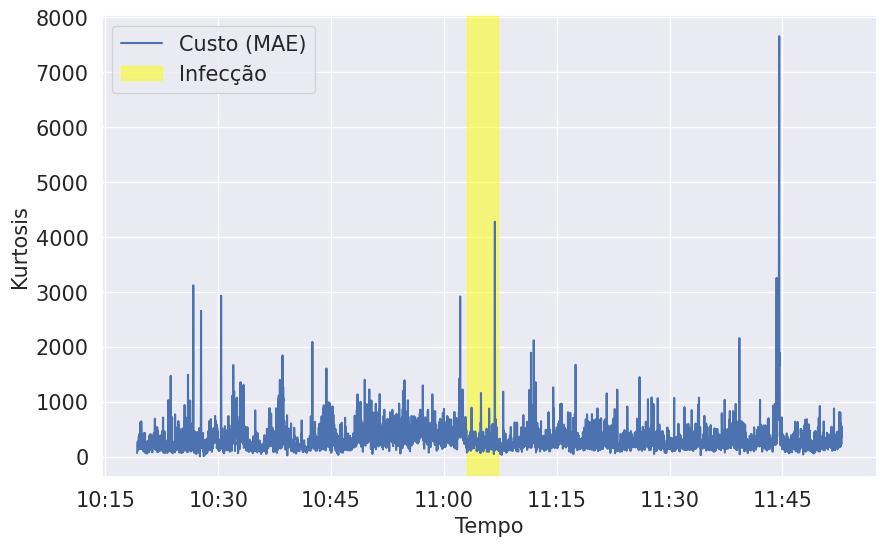

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

axs.plot(new_df['tcp_time_delta_kurt'])
axs.axvspan(pd.to_datetime('2011-08-18 11:03:05').tz_localize('Europe/Berlin'), pd.to_datetime('2011-08-18 11:07:15').tz_localize('Europe/Berlin'), color='yellow', alpha=0.5, label='Infecção')
labels = ['Custo (MAE)', 'Infecção']
axs.legend(loc="upper left", labels=labels)
axs.set(xlabel='Tempo', ylabel='Kurtosis')

In [18]:
train = new_df.iloc[:1879]
test = new_df.iloc[1879:3758]
test_2 = new_df.iloc[3758:]
print("Training dataset shape: ", train.shape)
print("Validation dataset shape: ", test.shape)
print("Test dataset shape: ", test_2.shape)

Training dataset shape:  (1879, 6)
Validation dataset shape:  (1879, 6)
Test dataset shape:  (1878, 6)


In [19]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.fit_transform(test)
X_test_2 = scaler.fit_transform(test_2)
scaler_filename = 'scaler_data'
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [20]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape: ", X_test.shape)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 1, X_test_2.shape[1])
print("Test data shape: ", X_test_2.shape)

Training data shape: (1879, 1, 6)
Test data shape:  (1879, 1, 6)
Test data shape:  (1878, 1, 6)


In [21]:
def autoencoder_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model 

In [22]:
X_train

array([[[0.4843272 , 0.00239121, 0.0930444 , 0.01895544, 0.41508507,
         0.08837861]],

       [[0.51779895, 0.00788438, 0.14333405, 0.03506186, 0.40635174,
         0.08243435]],

       [[0.53416566, 0.01135393, 0.18026249, 0.05063095, 0.43247336,
         0.10026236]],

       ...,

       [[0.41943182, 0.02140548, 0.45796687, 0.22985429, 0.48061081,
         0.15135781]],

       [[0.4186337 , 0.02793526, 0.33727505, 0.11853673, 0.5072381 ,
         0.17498274]],

       [[0.44378065, 0.01921851, 0.48790944, 0.23408896, 0.48720625,
         0.15966198]]])

In [23]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1472      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [24]:
print(X_train.shape)

(1879, 1, 6)


In [25]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.10).history

Epoch 1/100
170/170 [==============================] - 7s 10ms/step - loss: 0.1629 - val_loss: 0.0955
Epoch 2/100
170/170 [==============================] - 1s 5ms/step - loss: 0.0570 - val_loss: 0.0691
Epoch 3/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0486 - val_loss: 0.0644
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0476 - val_loss: 0.0622
Epoch 5/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0467 - val_loss: 0.0603
Epoch 6/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0455 - val_loss: 0.0544
Epoch 7/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0446 - val_loss: 0.0537
Epoch 8/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0438 - val_loss: 0.0527
Epoch 9/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0430 - val_loss: 0.0508
Epoch 10/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0423 - val_l

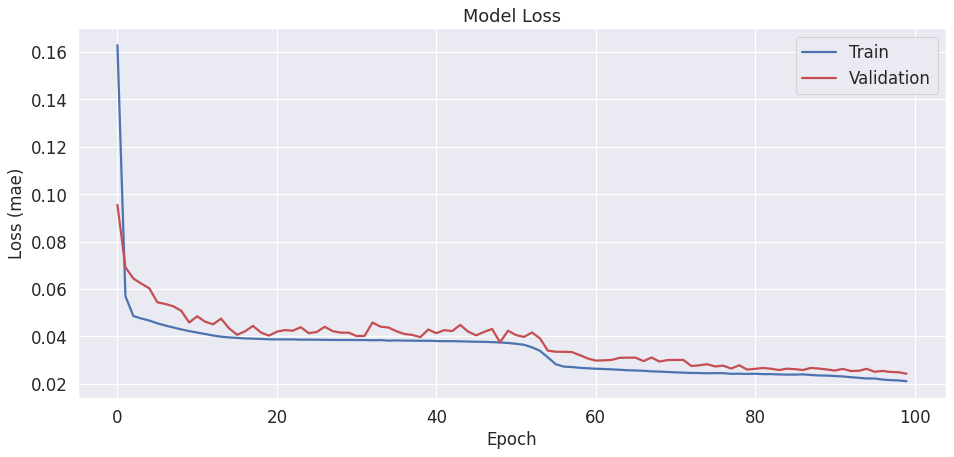

In [26]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [97]:
from tensorflow import keras

model = keras.models.load_model('lstm_autoencoder_ctu13_cap51_2.h')

In [98]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index.tz_convert('Europe/Berlin')
X_pred_train

59/59 [==============================] - 1s 2ms/step


,frame_len_skew,frame_len_kurt,tcp_time_delta_skew,tcp_time_delta_kurt,tcp_window_size_skew,tcp_window_size_kurt
frame.time,,,,,,
2011-08-18 10:19:13+02:00,0.565111,0.059827,0.187657,0.043758,0.402733,0.094673
2011-08-18 10:19:14+02:00,0.547377,0.042865,0.188063,0.042767,0.396684,0.091527
2011-08-18 10:19:15+02:00,0.532297,0.032044,0.193688,0.044234,0.425361,0.107844
2011-08-18 10:19:16+02:00,0.529448,0.025455,0.195197,0.046534,0.357875,0.070215
2011-08-18 10:19:17+02:00,0.517004,0.024459,0.231635,0.067352,0.357261,0.069360
...,...,...,...,...,...,...
2011-08-18 10:50:23+02:00,0.461188,0.027284,0.385383,0.169909,0.436599,0.120158
2011-08-18 10:50:24+02:00,0.486047,0.020969,0.293036,0.098444,0.483530,0.140326
2011-08-18 10:50:25+02:00,0.439180,0.034633,0.452091,0.231123,0.470099,0.151050


59/59 [==============================] - 0s 2ms/step


<ipython-input-99-398a8f4f2a71>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored_train['Loss_mae'], bins = 50, kde=True, color = 'navy')


Text(0, 0.5, 'Density')

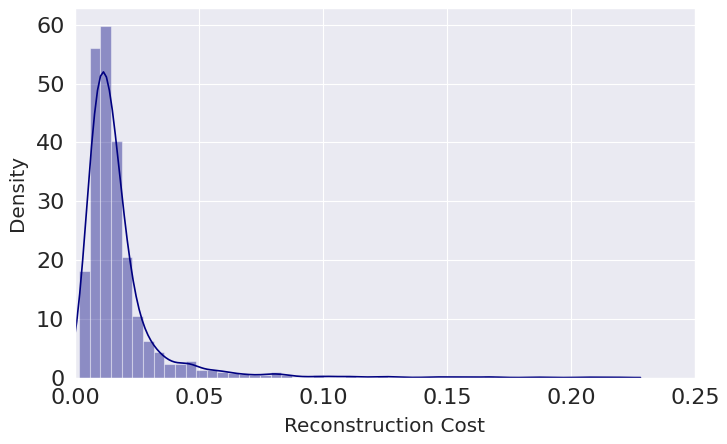

In [99]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index.tz_convert('Europe/Berlin'))
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
plt.figure(figsize=(10,6), dpi=80)
sns.distplot(scored_train['Loss_mae'], bins = 50, kde=True, color = 'navy')
sns.set(font_scale=1.4)
plt.xlim([0.0,.25])
plt.xlabel("Reconstruction Cost", fontsize=18, labelpad=8.0)
plt.ylabel("Density", fontsize=18, labelpad=8.0)

In [100]:
X_test_full = np.concatenate((X_test, X_test_2), axis=0)
test_full = pd.concat([test, test_2])

In [101]:
X_pred_test_full = model.predict(X_test_full)
X_pred_test_full = X_pred_test_full.reshape(X_pred_test_full.shape[0], X_pred_test_full.shape[2])
X_pred_test_full = pd.DataFrame(X_pred_test_full, columns=test_full.columns)
X_pred_test_full.index = test_full.index

scored_test_full = pd.DataFrame(index=test_full.index)
Xtest_full = X_test_full.reshape(X_test_full.shape[0], X_test_full.shape[2])

118/118 [==============================] - 0s 2ms/step


In [102]:
scored_test_full['Loss_mae'] = np.mean(np.abs(X_pred_test_full-Xtest_full), axis = 1)
scored_test_full['Threshold'] = 0.2
scored_test_full['Anomaly'] = scored_test_full['Loss_mae'] > scored_test_full['Threshold']
scored_test_full.tail()

,Loss_mae,Threshold,Anomaly
frame.time,,,
2011-08-18 11:52:49+02:00,0.023903,0.2,False
2011-08-18 11:52:50+02:00,0.047816,0.2,False
2011-08-18 11:52:51+02:00,0.047424,0.2,False
2011-08-18 11:52:52+02:00,0.033686,0.2,False
2011-08-18 11:52:53+02:00,0.050057,0.2,False


In [103]:
data_label = pd.DataFrame()
data_label['label'] = df['Class']
data_label['label'] = data_label['label'].astype(int)
data_label['label'].value_counts()
data_label = data_label[1879:5636]

In [104]:
data_label

,label
frame.time,
2011-08-18 10:50:28+02:00,0
2011-08-18 10:50:29+02:00,0
2011-08-18 10:50:30+02:00,0
2011-08-18 10:50:30+02:00,0
2011-08-18 10:50:31+02:00,0
...,...
2011-08-18 11:52:49+02:00,1
2011-08-18 11:52:50+02:00,1
2011-08-18 11:52:51+02:00,0


In [105]:
scored_test_full

,Loss_mae,Threshold,Anomaly
frame.time,,,
2011-08-18 10:50:28+02:00,0.077744,0.2,False
2011-08-18 10:50:29+02:00,0.085150,0.2,False
2011-08-18 10:50:30+02:00,0.076986,0.2,False
2011-08-18 10:50:30+02:00,0.140767,0.2,False
2011-08-18 10:50:31+02:00,0.117417,0.2,False
...,...,...,...
2011-08-18 11:52:49+02:00,0.023903,0.2,False
2011-08-18 11:52:50+02:00,0.047816,0.2,False
2011-08-18 11:52:51+02:00,0.047424,0.2,False


In [106]:
concatenated = scored_test_full
concatenated['label'] = data_label['label']

In [107]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["date.autoformatter.minute"] = "%H:%M"

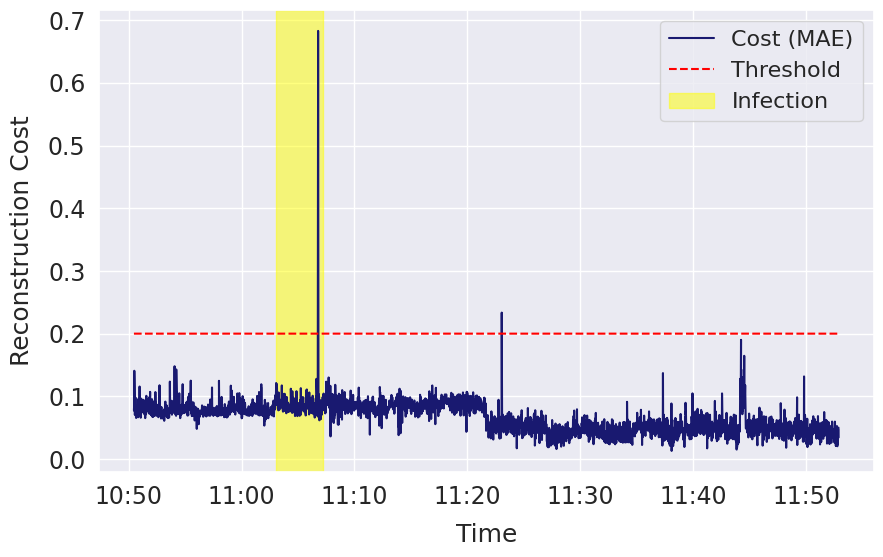

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(17)

ax.plot(concatenated['Loss_mae'], label='Cost (MAE)', color='midnightblue')
ax.plot(concatenated['Threshold'], label='Threshold', color = 'red', linestyle='dashed')

plt.axvspan(pd.to_datetime('2011-08-18 11:03:05').tz_localize('Europe/Berlin'), pd.to_datetime('2011-08-18 11:07:15').tz_localize('Europe/Berlin'), color='yellow', alpha=0.5, label='Infection')
plt.xlabel("Time", fontsize=18, labelpad=10.0)
plt.ylabel("Reconstruction Cost", fontsize=18, labelpad=10.0)

leg = ax.legend(prop={"size":16})

In [109]:
ews_scored = concatenated['2011-08-18 11:03:05':]

[Text(0.5, 6.049999999999999, 'Valor Predito'),
 Text(33.24999999999999, 0.5, 'Valor Real')]

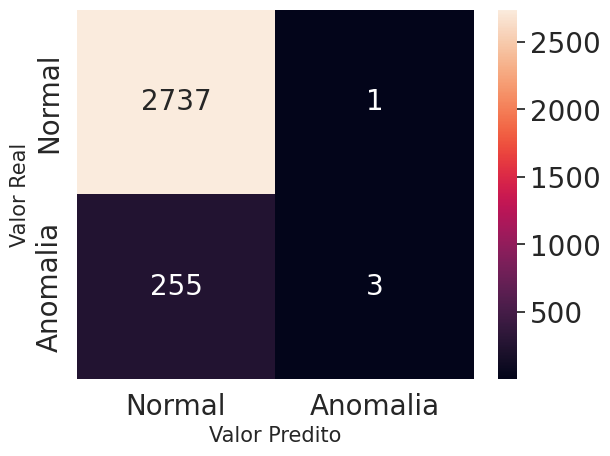

In [110]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

xticklabels=['Normal', 'Anomalia'] 
yticklabels=['Normal', 'Anomalia']
cm = confusion_matrix(ews_scored['label'], ews_scored['Anomaly'])
s = sns.heatmap(cm, annot=True, fmt='d', xticklabels=xticklabels, yticklabels=yticklabels)
s.set(xlabel='Valor Predito', ylabel='Valor Real')

In [111]:
tn, fp, fn, tp = confusion_matrix(ews_scored['label'], ews_scored['Anomaly']).ravel()

print('fp: ' + str(fp))
print('tp: ' + str(tp))
print('fn: ' + str(fn))
print('tn: ' + str(tn))

accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'F1 Score = {round(f1_score, 2)}')
print(f'Accuracy = {round(accuracy, 2)}')
print(f'Precision = {round(precision, 2)}')
print(f'Recall = {round(recall, 2)}')

fp: 1
tp: 3
fn: 255
tn: 2737
F1 Score = 0.02
Accuracy = 0.91
Precision = 0.75
Recall = 0.01


In [112]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(ews_scored['label'], ews_scored['Anomaly']))
print(classification_report(ews_scored['label'], ews_scored['Anomaly']))

[[2737    1]
 [ 255    3]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      2738
           1       0.75      0.01      0.02       258

    accuracy                           0.91      2996
   macro avg       0.83      0.51      0.49      2996
weighted avg       0.90      0.91      0.88      2996

